In [20]:
# def dloss_dm_func(m, c):
#     return (
#         -2 * (1.4 + (-0.5 * m) - c) * 0.5 + 
#         -2 * (1.9 + (-2.3 * m) - c) * 2.3 + 
#         -2 * (3.2 + (-2.9 * m) - c) * 2.9
#     )

# def dloss_dc_func(m, c):
#     return (
#         -2 * (1.4 +(-0.5 * m) - c) + 
#         -2 * (1.9 +(-2.3 * m) - c) + 
#         -2 * (3.2 +(-2.9 * m) - c)
#     )

def dloss_dm_func(data, m, c):
    return sum(-2 * x * (y - (m * x + c)) for x, y in data)

def dloss_dc_func(data, m, c):
    return sum(-2 * (y - (m * x + c)) for x, y in data)

def predict(x, m, c):
    return m * x + c

def loss(datas, m, c):
    total = 0
    for data in datas:
        total += (data[1]-predict(data[0], m, c))**2
    return total/3

In [21]:
import random
import pandas as pd

data = [
    [0.5, 1.4],
    [2.3, 1.9],
    [2.9, 3.2]
]


limit = 0.000001
step_limit = 1000
alpha = 0.01

def gradient_descent(data, limit, step_limit, alpha):
    log = {
        "step":[],
        "m":[], 
        "c":[], 
        "loss_val":[], 
        "dloss_dm":[], 
        "dloss_dc":[]
    }
    m = random.randint(0,1)*5
    c = random.randint(0,1)*5
    dloss_dm, dloss_dc = 100, 100

    step = 0
    while (step < step_limit) and (abs(dloss_dm) > limit or abs(dloss_dc) > limit):
        loss_val = loss(data, m, c)
        # dloss_dm = dloss_dm_func(m, c)
        # dloss_dc = dloss_dc_func(m, c)
        dloss_dm = dloss_dm_func(data, m, c)
        dloss_dc = dloss_dc_func(data, m, c)
        m -= alpha * dloss_dm
        c -= alpha * dloss_dc
        log["step"].append(step)
        log["m"].append(m)
        log["c"].append(c)
        log["loss_val"].append(loss_val)
        log["dloss_dm"].append(dloss_dm)
        log["dloss_dc"].append(dloss_dc)
        step += 1
    return m, c, log

m, c, log = gradient_descent(data, limit, step_limit, alpha)


df_log = pd.DataFrame(log)

In [22]:
df_log.head()

step         m         c  loss_val   dloss_dm   dloss_dc
0     0 -0.283000  4.830000  8.603333  28.300000  17.000000
1     1 -0.467663  4.702462  5.554499  18.466300  12.753800
2     2 -0.586266  4.603628  4.139948  11.860269   9.883414
3     3 -0.660511  4.524244  3.465177   7.424545   7.938338
4     4 -0.704992  4.458088  3.125704   4.448126   6.615640

In [32]:
import numpy as np
import plotly.graph_objects as go

# Create the loss surface
m_vals = np.linspace(df_log['m'].min()*1.2, df_log['m'].max()*1.2, 500)
c_vals = np.linspace(df_log['c'].min()*1.2, df_log['c'].max()*1.2, 500)

# Create meshgrid
M, C = np.meshgrid(m_vals, c_vals)

# Calculate loss for each combination
Z = np.zeros_like(M)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        Z[i, j] = loss(data, M[i, j], C[i, j])

# Sort the trajectory data
df_sorted = df_log.sort_values("step")

# Create figure with both surface and trajectory
fig = go.Figure()

# Add surface plot
fig.add_trace(go.Surface(
    x=m_vals,
    y=c_vals,
    z=Z,
    colorscale='Viridis',
    name='Loss Surface',
    contours={
        "z": {
            "show": True,
            "usecolormap": True,
            "highlightcolor": "limegreen",
            "project": {"z": True}
        }
    },
    opacity=0.9
))

# Add gradient descent trajectory
fig.add_trace(go.Scatter3d(
    x=df_sorted['m'],
    y=df_sorted['c'],
    z=df_sorted['loss_val'],
    mode='lines+markers',
    name='Gradient Descent Path',
    line=dict(color='red', width=4),
    marker=dict(size=4, color='red')
))

fig.update_layout(
    title='Loss Surface with Gradient Descent Trajectory',
    width=1000,
    height=700,
    scene=dict(
        xaxis_title='m',
        yaxis_title='c',
        zaxis_title='loss_val',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    )
)

fig.show()



In [24]:
import seaborn as sns

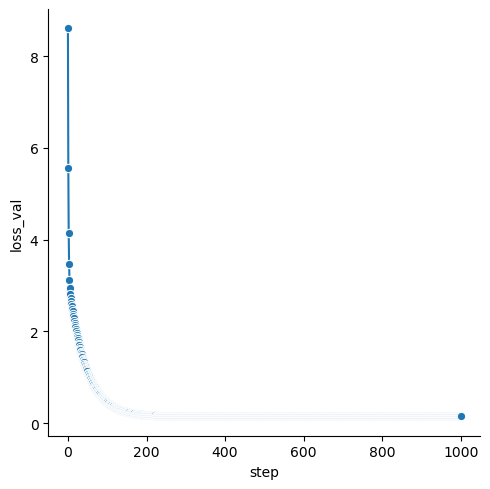

In [25]:
sns.relplot(data=df_log, x="step", y="loss_val", kind="line", marker="o")

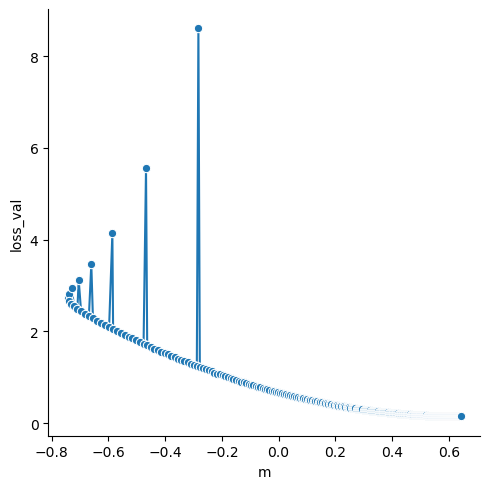

In [26]:
sns.relplot(data=df_log, x="m", y="loss_val", kind="line", marker="o")

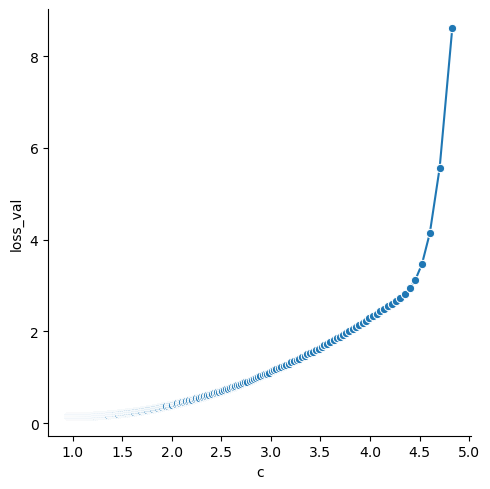

In [27]:
sns.relplot(data=df_log, x="c", y="loss_val", kind="line", marker="o")

In [28]:
df_data =pd.DataFrame(data, columns=["x","y"])

In [29]:
df_data

x    y
0  0.5  1.4
1  2.3  1.9
2  2.9  3.2

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from prefixed import Float

def regress_grid(df_data, df_log, steps, cols=5):
    """Plot multiple regression lines in a grid of subplots."""
    
    rows = int(np.ceil(len(steps) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True, sharey=True)
    axes = axes.flatten()  # Make it easy to index

    x_vals = np.linspace(df_data["x"].min(), df_data["x"].max(), 100)

    for i, step in enumerate(steps):
        ax = axes[i]
        
        # Get slope and intercept safely
        row = df_log.loc[df_log["step"] == step]
        if row.empty:
            ax.text(0.5, 0.5, f"No data for step {step}", ha="center", va="center")
            ax.axis("off")
            continue
        
        m = row["m"].iloc[0]
        c = row["c"].iloc[0] if "c" in df_log.columns else 0
        error = row["loss_val"].iloc[0]
        print(error)

        # Scatter + regression line
        sns.scatterplot(data=df_data, x="x", y="y", ax=ax, s=30)
        ax.plot(x_vals, m * x_vals + c, color="red", linewidth=2)

        # Titles and cleanup
        ax.set_title(f"Step {step}; error: {error:.2e}\ny = {m:.2e}x + {c:.2e}", fontsize=10)
        ax.grid(True, alpha=0.3)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle("Regression Lines by Step", fontsize=16)
    plt.tight_layout()
    plt.show()


# Example usage
steps = range(0, 1000, 111)
regress_grid(df_data, df_log, steps, cols=9)


ModuleNotFoundError: No module named 'prefixed'

In [ ]:
df_log.iloc[999]

step        999.000000
m             0.641018
c             0.948737
loss_val      0.148205
dloss_dm     -0.000009
dloss_dc      0.000022
Name: 999, dtype: float64

999.0


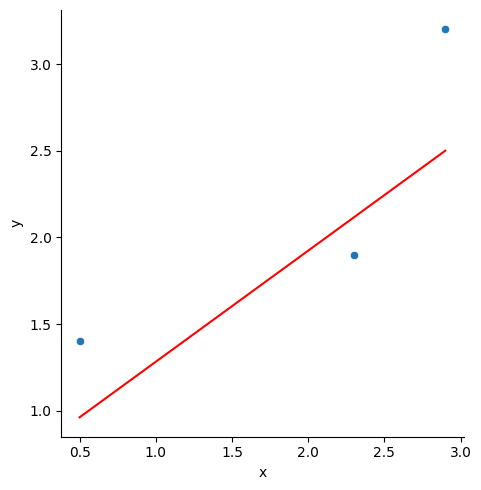

In [ ]:
step = df_log.iloc[-1,:]["step"]
print(step)
g = sns.relplot(data=df_data, x="x", y="y") 
ax = g.ax 
x_vals = np.linspace(df_data["x"].min(), df_data["x"].max(), 100) 
y_vals = df_log[df_log["step"]==step]["m"].iloc[0] * x_vals + df_log[df_log["step"]==step]["m"].iloc[0] 
# Plot the line 
ax.plot(x_vals, y_vals, color="red", label=f"y = {m}x + {c}") 
plt.show()

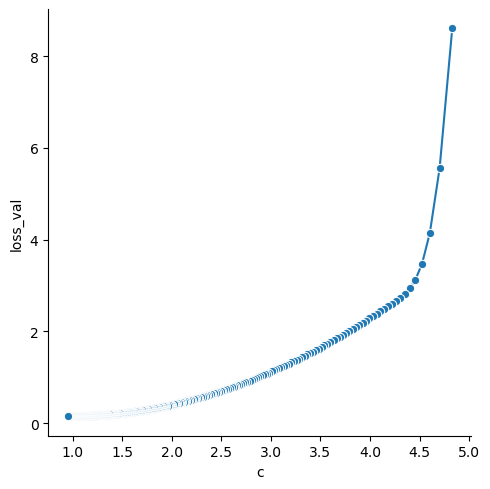

In [ ]:
df_log_sorted = df_log.sort_values("step")
sns.relplot(data=df_log_sorted, x="m", y="loss_val", kind="line", marker="o", sort=False)

In [ ]:
m, c, log = gradient_descent(data, limit, step_limit, 0.07)
df_log = pd.DataFrame(log)

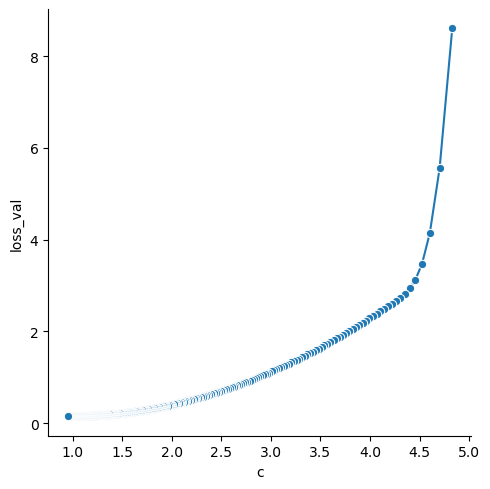

In [ ]:
df_log_sorted = df_log.sort_values("step")
sns.relplot(data=df_log_sorted, x="m", y="loss_val", kind="line", marker="o", sort=False)